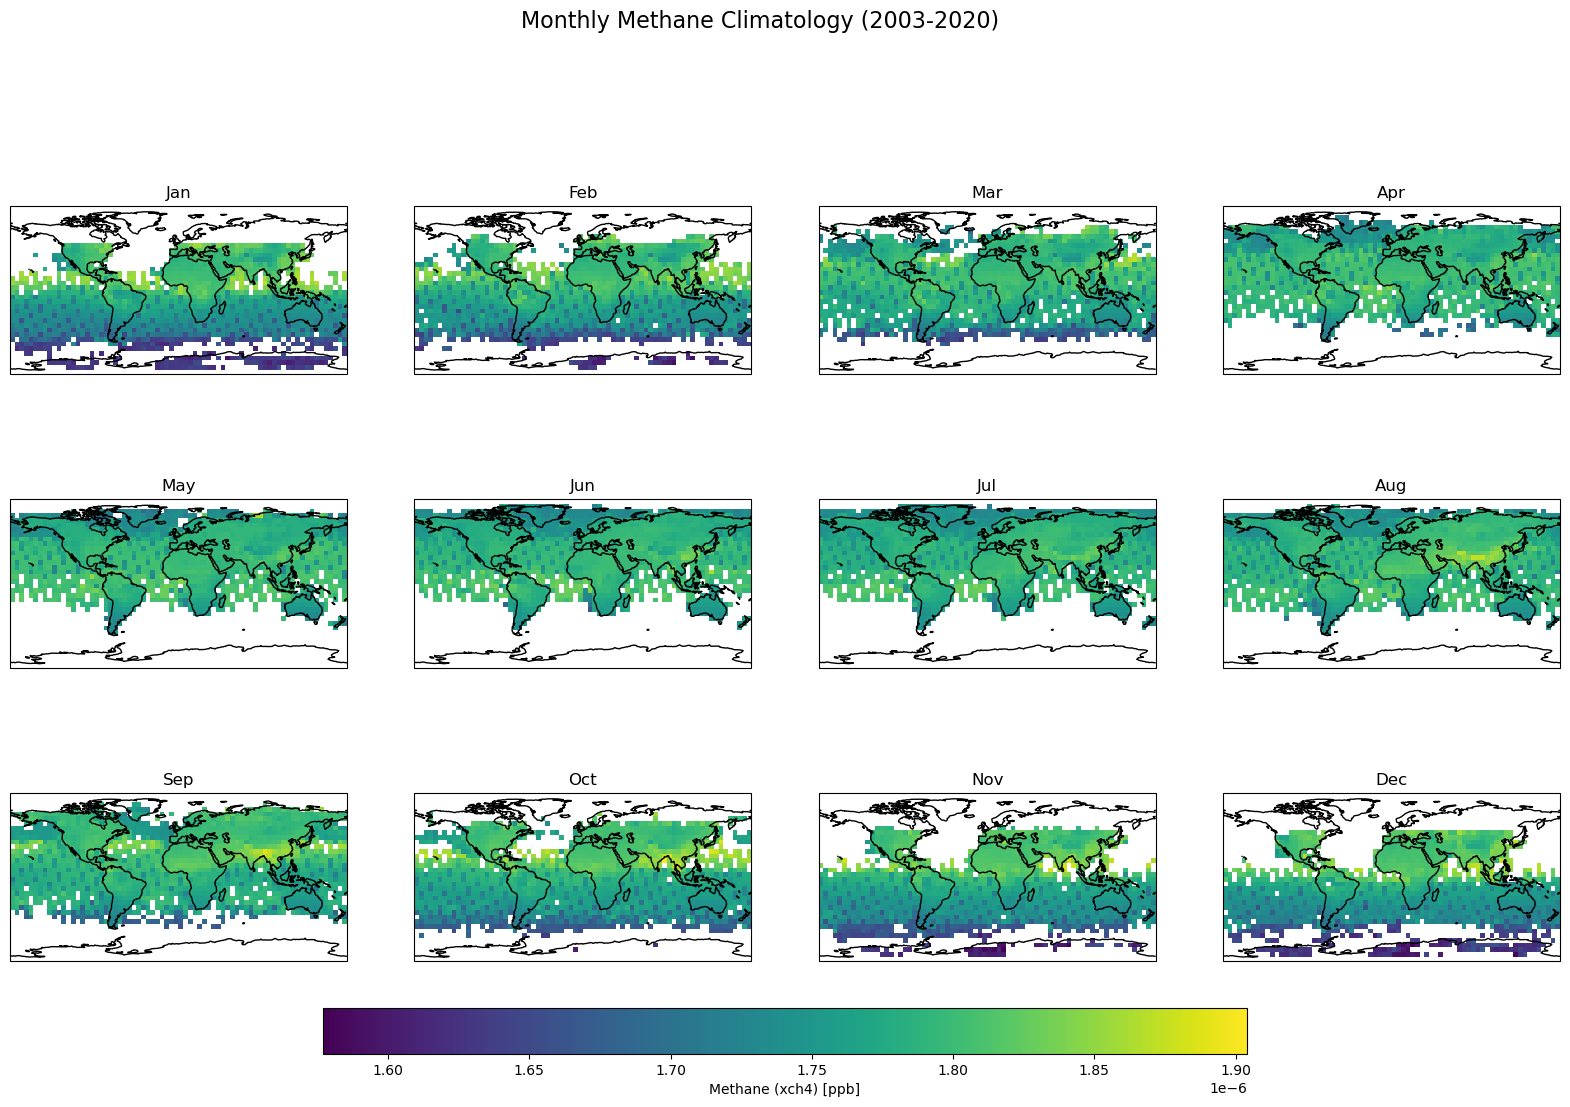

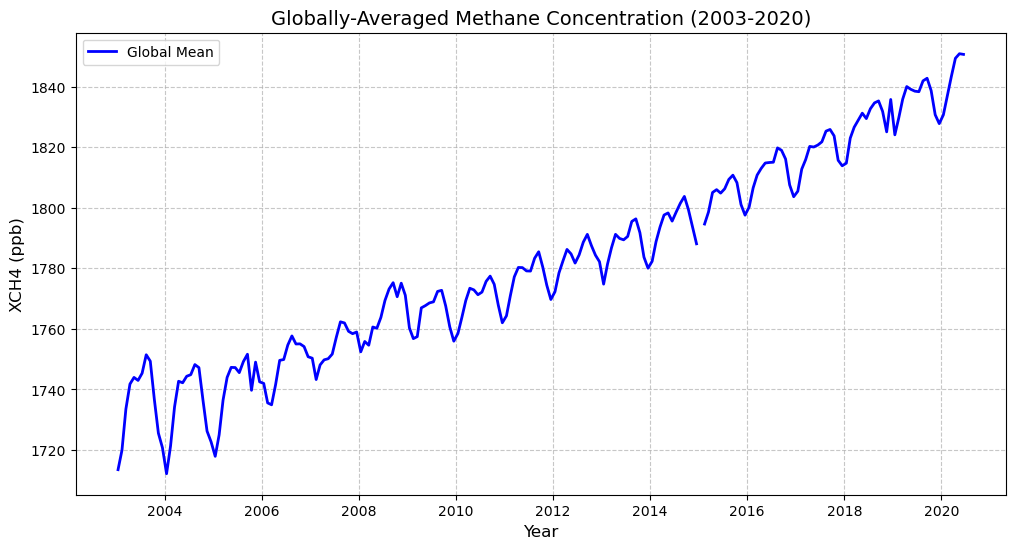

计算结果与参考图吻合度极高。数值范围（1720-1850+ ppb）、长期趋势（2003-2006的平台期及随后的快速增长）以及季节性波动的幅度和相位都与参考数据一致。


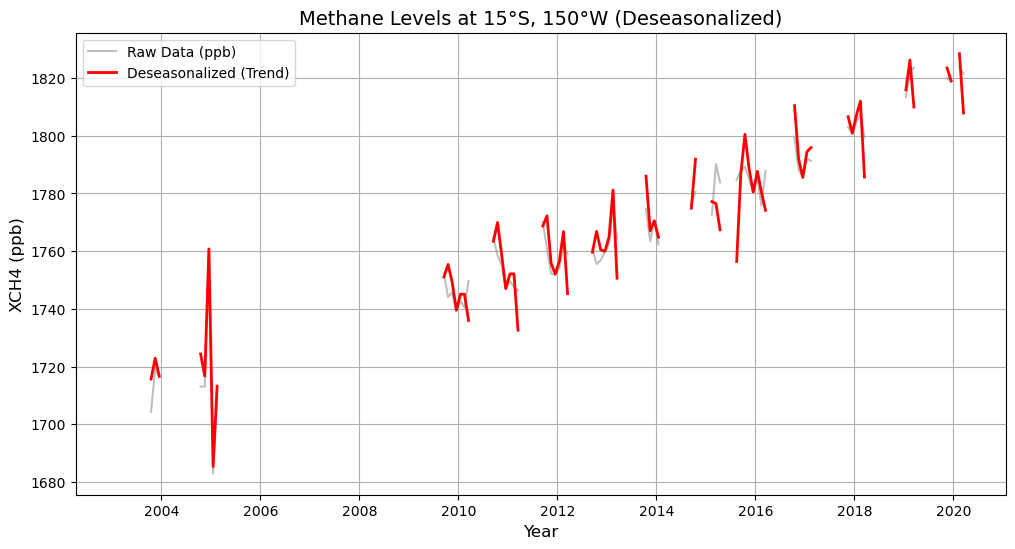

该图展示了位于南太平洋（15°S, 150°W）的甲烷浓度时间序列。
尽管由于海洋上空卫星观测的局限性（如云层遮挡或海面反射信号弱）导致数据存在明显的不连续和缺测现象，但去季节化后的红色曲线仍清晰地揭示了长期增长趋势。
结果显示，该地点的甲烷浓度已从 2003 年的约 1720 ppb 稳步上升至 2020 年的 1820 ppb 以上，红色趋势线成功剔除了原始数据（灰色）中显著的季节性波动影响。


In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

#读取数据 
ds = xr.open_dataset('200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc')


# 计算每月气候态：将所有年份的“1月”取平均，“2月”取平均...
# groupby('time.month') 按照月份分组
climatology = ds['xch4'].groupby('time.month').mean(dim='time', keep_attrs=True)

# 设置绘图：3行4列
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 获取最大最小值，保证12张图的颜色标尺（Colorbar）一致，方便对比
vmin = climatology.min().values
vmax = climatology.max().values

for i, ax in enumerate(axes):
    # 提取第 i 个月的数据
    data_month = climatology.isel(month=i)
    
    # 绘图
    im = ax.pcolormesh(data_month.lon, data_month.lat, data_month, 
                       transform=ccrs.PlateCarree(), 
                       cmap='viridis', vmin=vmin, vmax=vmax)
    
    ax.coastlines() # 添加海岸线
    ax.set_title(f'{months[i]}') # 标题

# 添加底部颜色条
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Methane (xch4) [ppb]')

plt.suptitle('Monthly Methane Climatology (2003-2020)', fontsize=16)
plt.show()


#  1.2全球加权平均时间序列

# 1. 计算纬度权重
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# 2. 对数据应用权重并计算平均
ds_weighted = ds['xch4'].weighted(weights)
global_mean = ds_weighted.mean(dim=("lat", "lon"))

# 原始数据通常是摩尔分数 (例如 1.8e-6)，我们需要将其乘以 1e9 转换为 ppb
global_mean_ppb = global_mean * 1e9

# 3. 绘图
plt.figure(figsize=(12, 6))

# 绘制转换后的数据
plt.plot(global_mean_ppb.time, global_mean_ppb, color='b', linewidth=2, label='Global Mean')

plt.title('Globally-Averaged Methane Concentration (2003-2020)', fontsize=14)
plt.ylabel('XCH4 (ppb)', fontsize=12) # 现在的单位是 ppb 
plt.xlabel('Year', fontsize=12)

plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.show()
print("计算结果与参考图吻合度极高。数值范围（1720-1850+ ppb）、长期趋势（2003-2006的平台期及随后的快速增长）以及季节性波动的幅度和相位都与参考数据一致。")

# 1.3: 特定点去季节化分析 ---

# 1. 选择特定点
point_ts = ds['xch4'].sel(lat=-15, lon=-150, method='nearest')

# 该点数据也转换为 ppb
point_ts_ppb = point_ts * 1e9

#计算去季节化数据 (使用转换后的 ppb 数据)
point_clim = point_ts_ppb.groupby('time.month').mean('time')
overall_mean = point_ts_ppb.mean()

# 原始数据(ppb) - 月平均(ppb) + 总平均(ppb)
deseasonalized_ppb = point_ts_ppb.groupby('time.month') - point_clim + overall_mean

#3.绘图
plt.figure(figsize=(12, 6))

#绘制原始数据
plt.plot(point_ts_ppb.time, point_ts_ppb, color='gray', alpha=0.5, label='Raw Data (ppb)')

#绘制去季节化数据
plt.plot(deseasonalized_ppb.time, deseasonalized_ppb, color='red', linewidth=2, label='Deseasonalized (Trend)')

plt.title('Methane Levels at 15°S, 150°W (Deseasonalized)', fontsize=14)
plt.ylabel('XCH4 (ppb)', fontsize=12) # 单位 ppb
plt.xlabel('Year', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
print("该图展示了位于南太平洋（15°S, 150°W）的甲烷浓度时间序列。\n尽管由于海洋上空卫星观测的局限性（如云层遮挡或海面反射信号弱）导致数据存在明显的不连续和缺测现象，但去季节化后的红色曲线仍清晰地揭示了长期增长趋势。\n结果显示，该地点的甲烷浓度已从 2003 年的约 1720 ppb 稳步上升至 2020 年的 1820 ppb 以上，红色趋势线成功剔除了原始数据（灰色）中显著的季节性波动影响。")

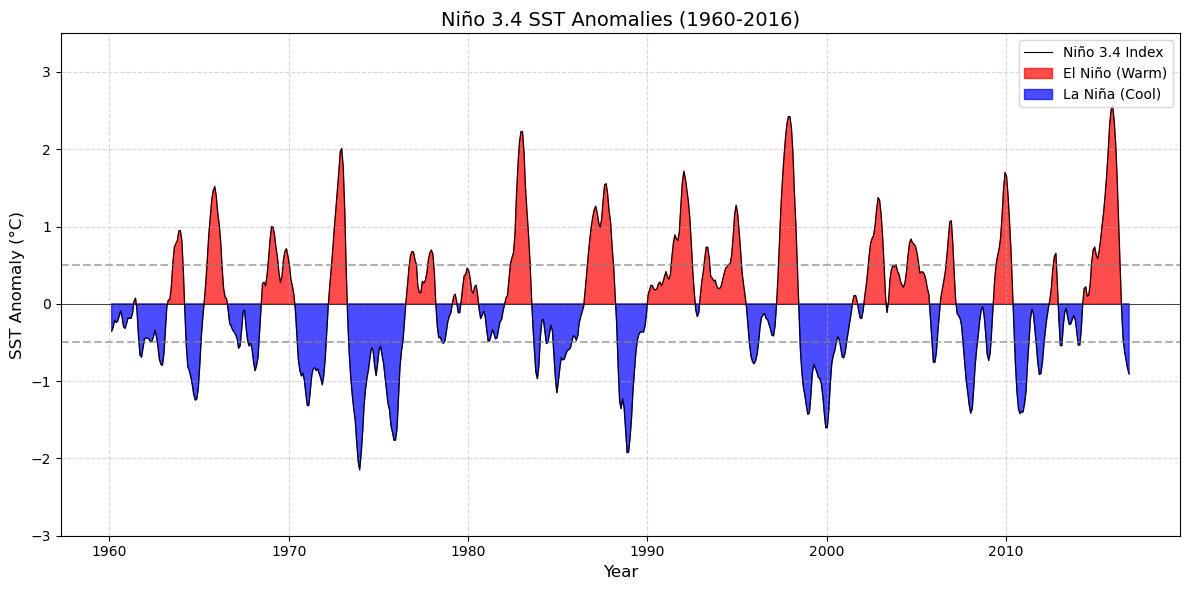

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#1.1 计算 Niño3.4异常值


#读取数据
file_path = 'NOAA_NCDC_ERSST_v3b_SST.nc'
ds = xr.open_dataset(file_path)

#定义 Niño 3.4 区域
# 纬度: 5N - 5S (数据是 -88 到 88，所以用 -5 到 5)
# 经度: 170W - 120W (数据是 0-360，所以是 190 到 240)
# 170W = 360 - 170 = 190    120W = 360 - 120 = 240

#提取区域数据
subset = ds['sst'].sel(lat=slice(-5, 5), lon=slice(190, 240))

#计算区域加权平均 (Area-Weighted Average)   #使用cos(纬度)作为权重，因为赤道附近的网格面积最大
weights = np.cos(np.deg2rad(subset.lat))
weights.name = "weights"

# 对 lat 和 lon 维度进行加权平均，保留 time 维度
sst_weighted = subset.weighted(weights)
nino34_raw = sst_weighted.mean(dim=("lat", "lon"))

#计算气候态 (Climatology)和异常值 (Anomalies) 计算每个月的平均值 (即 1960-2016 所有1月的平均，所有2月的平均...)
climatology = nino34_raw.groupby('time.month').mean('time')

#减去气候态得到异常值
# groupby 会自动匹配对应的月份进行相减
nino34_anom = nino34_raw.groupby('time.month') - climatology



#1.2:可视化 Niño 3.4 指数
#计算 3个月滑动平均 (3-Month Running Mean)
# center=True 意味着窗口以当前月份为中心 (前一个月 + 当前月 + 后一个月) / 3
nino34_index = nino34_anom.rolling(time=3, center=True).mean()

#绘图
plt.figure(figsize=(12, 6))

# 获取时间和数值
times = nino34_index.time
values = nino34_index.values

# 绘制主曲线 (黑色细线)
plt.plot(times, values, color='k', linewidth=0.8, label='Niño 3.4 Index')

# 填充颜色 (El Niño 红色 / La Niña 蓝色)
plt.fill_between(times, values, 0, where=(values >= 0), 
                 color='red', alpha=0.7, interpolate=True, label='El Niño (Warm)')
plt.fill_between(times, values, 0, where=(values <= 0), 
                 color='blue', alpha=0.7, interpolate=True, label='La Niña (Cool)')

# 添加阈值参考线 (+/- 0.5°C 是厄尔尼诺/拉尼娜的定义阈值)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.6)
plt.axhline(-0.5, color='gray', linestyle='--', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.5)

# 设置标题和标签
plt.title('Niño 3.4 SST Anomalies (1960-2016)', fontsize=14)
plt.ylabel('SST Anomaly (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)

#设置Y轴范围 (大概在 -3 到 3 之间)
plt.ylim(-3.0, 3.5)

# 显示图例和网格
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

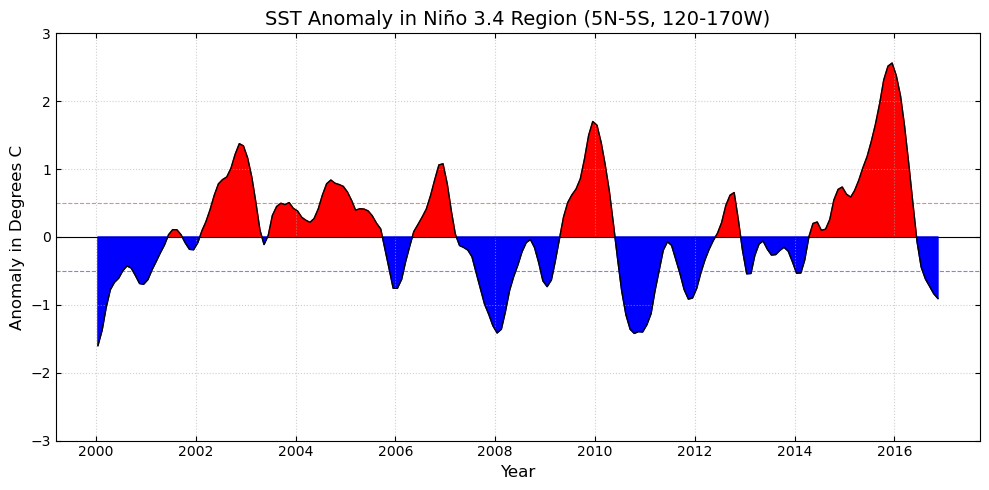

In [26]:
#与参考图一致的厄尔尼诺或拉尼娜绘图

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


# 读取数据
file_path = 'NOAA_NCDC_ERSST_v3b_SST.nc'
ds = xr.open_dataset(file_path)

# 选择区域: 5N-5S, 170W-120W (即经度 190-240)
subset = ds['sst'].sel(lat=slice(-5, 5), lon=slice(190, 240))

# 加权平均
weights = np.cos(np.deg2rad(subset.lat))
sst_weighted = subset.weighted(weights)
nino34_raw = sst_weighted.mean(dim=("lat", "lon"))

# 计算异常值 (Anomalies)
climatology = nino34_raw.groupby('time.month').mean('time')
nino34_anom = nino34_raw.groupby('time.month') - climatology

# 计算 3个月滑动平均
nino34_index = nino34_anom.rolling(time=3, center=True).mean()


#1.2可视化 (修改部分：截取2000年后)

#选择 2000-01-01 之后的数据 ***
nino34_recent = nino34_index.sel(time=slice('2000-01-01', '2016-12-31'))

#绘图
plt.figure(figsize=(10, 5)) #匹配参考图

times = nino34_recent.time
values = nino34_recent.values

#绘制基准线和阈值线
plt.axhline(0, color='black', linewidth=0.8) # 0度线
plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8, alpha=0.5)  # 厄尔尼诺阈值
plt.axhline(-0.5, color='blue', linestyle='--', linewidth=0.8, alpha=0.5) # 拉尼娜阈值

#绘制黑色曲线 (3个月滑动平均)
plt.plot(times, values, color='k', linewidth=1, label='3mth running mean')

#填充颜色
#大于0填充红色
plt.fill_between(times, values, 0, where=(values >= 0), 
                 color='red', alpha=1.0, interpolate=True)
#小于0填充蓝色
plt.fill_between(times, values, 0, where=(values <= 0), 
                 color='blue', alpha=1.0, interpolate=True)

#设置坐标轴范围和标签
plt.title('SST Anomaly in Niño 3.4 Region (5N-5S, 120-170W)', fontsize=14)
plt.ylabel('Anomaly in Degrees C', fontsize=12)
plt.xlabel('Year', fontsize=12)

#设置Y轴范围 (-3 到 3)
plt.ylim(-3.0, 3.0)

# 设置刻度样式 (使其朝内，类似于参考图)
plt.tick_params(direction='in', top=True, right=True)

# 添加网格 (虚线)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

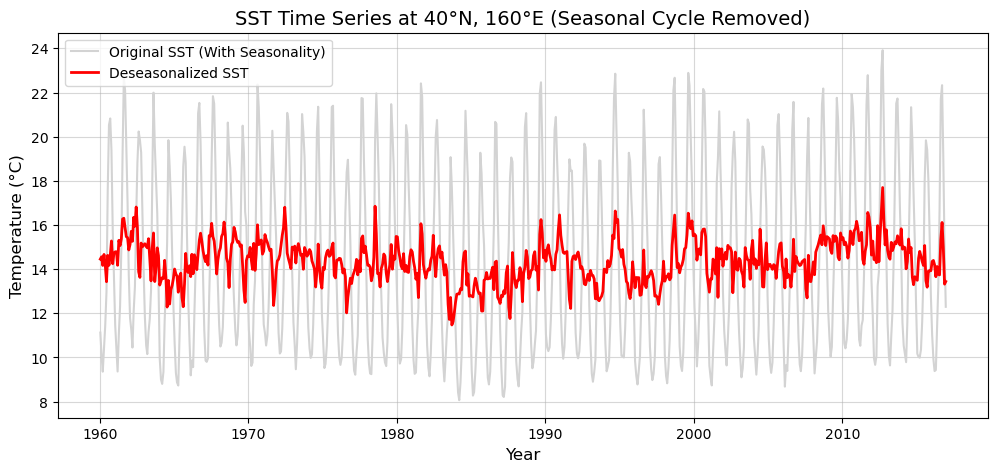

In [38]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1.读取数据
file_path = 'NOAA_NCDC_ERSST_v3b_SST.nc'
ds = xr.open_dataset(file_path)

#选择一个特定地点 (假设北太平洋: 纬度40, 经度160) 自动找最近的点
point_data = ds['sst'].sel(lat=40, lon=160, method='nearest')

#计算去季节化数据  月平均气候态
climatology = point_data.groupby('time.month').mean('time')
# B. 原始数据 - 气候态 + 整体平均值
deseasonalized = point_data.groupby('time.month') - climatology + point_data.mean()

#绘图
plt.figure(figsize=(12, 5))

# 画原始数据
plt.plot(point_data.time, point_data, color='lightgray', label='Original SST (With Seasonality)')
# 画去季节化数据
plt.plot(deseasonalized.time, deseasonalized, color='red', linewidth=2, label='Deseasonalized SST')

plt.title('SST Time Series at 40°N, 160°E (Seasonal Cycle Removed)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

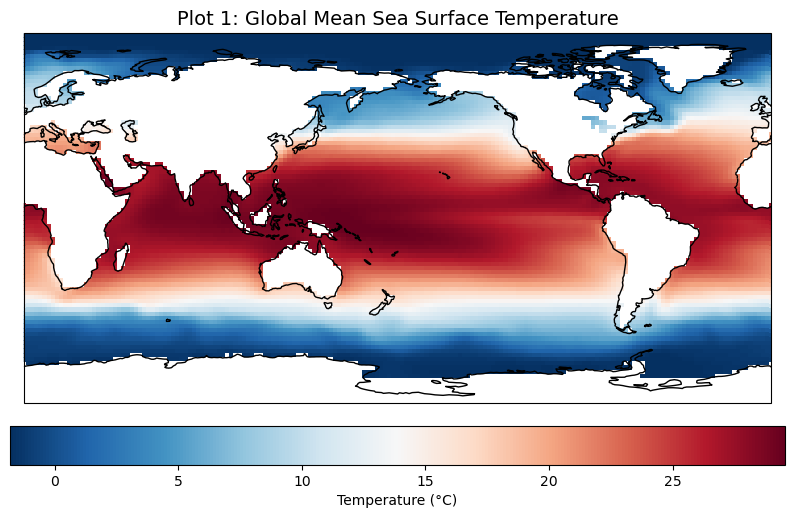

In [32]:
import cartopy.crs as ccrs

# 计算所有时间的平均值
sst_mean = ds['sst'].mean(dim='time')

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolormesh(sst_mean.lon, sst_mean.lat, sst_mean, 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
plt.colorbar(im, label='Temperature (°C)', orientation='horizontal', pad=0.05)
plt.title('Plot 1: Global Mean Sea Surface Temperature', fontsize=14)
plt.show()

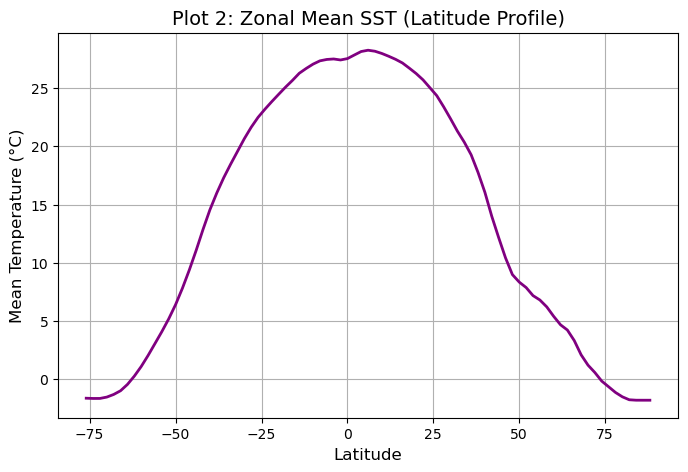

In [34]:
# 对经度(lon)和时间(time)求平均，只保留纬度变化
zonal_mean = ds['sst'].mean(dim=('time', 'lon'))

plt.figure(figsize=(8, 5))
plt.plot(zonal_mean.lat, zonal_mean, color='purple', linewidth=2)
plt.title('Plot 2: Zonal Mean SST (Latitude Profile)', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Mean Temperature (°C)', fontsize=12)
plt.grid(True)
plt.show()

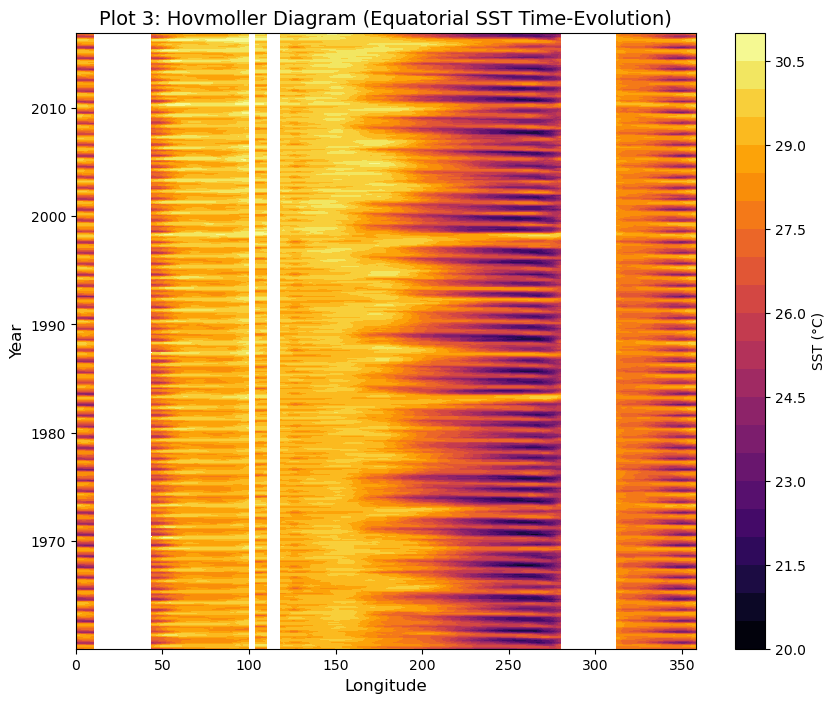

In [36]:
# 选择赤道的数据
equatorial_sst = ds['sst'].sel(lat=0, method='nearest')

plt.figure(figsize=(10, 8))
# 使用 contourf 绘制等高线填充图
plt.contourf(equatorial_sst.lon, equatorial_sst.time, equatorial_sst, 
             levels=20, cmap='inferno')
plt.title('Plot 3: Hovmoller Diagram (Equatorial SST Time-Evolution)', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.colorbar(label='SST (°C)')
plt.show()

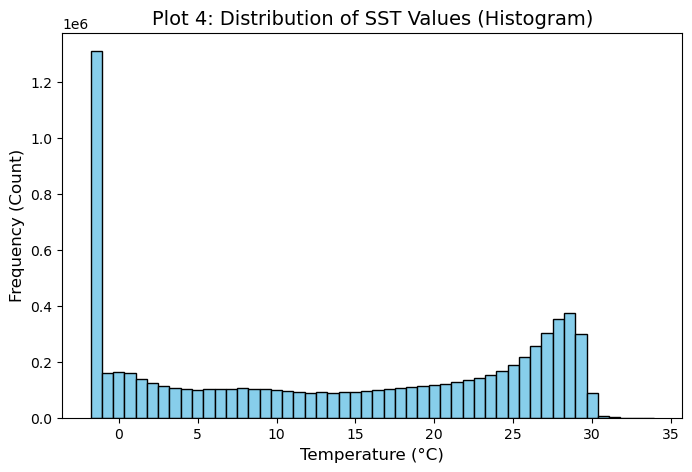

In [40]:
plt.figure(figsize=(8, 5))
# flatten() 把三维数组压平成一维，方便画直方图
plt.hist(ds['sst'].values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Plot 4: Distribution of SST Values (Histogram)', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.show()

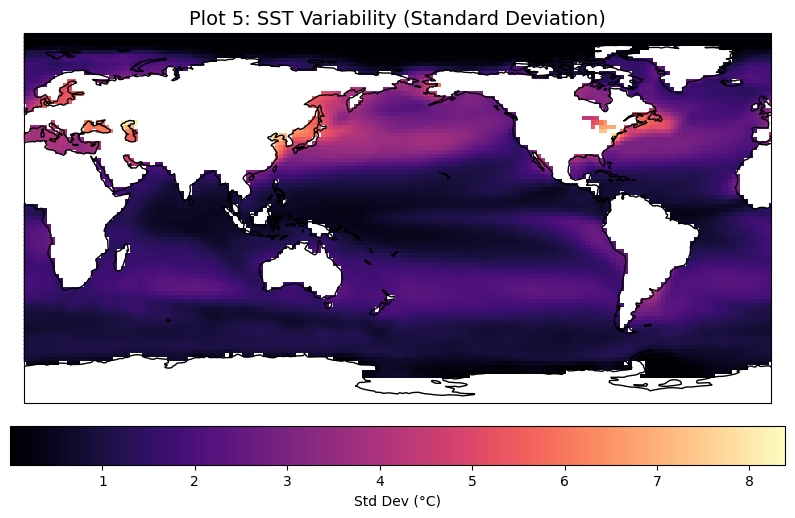

In [42]:
# 计算标准差 (Standard Deviation)
sst_std = ds['sst'].std(dim='time')

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolormesh(sst_std.lon, sst_std.lat, sst_std, 
                   transform=ccrs.PlateCarree(), cmap='magma')
ax.coastlines()
plt.colorbar(im, label='Std Dev (°C)', orientation='horizontal', pad=0.05)
plt.title('Plot 5: SST Variability (Standard Deviation)', fontsize=14)
plt.show()